# **Decision-Making Model for Flight Ticket Purchases**

## *Data Preprocessing*

In [22]:
# Loading necesarry libaries
import pandas as pd # For data manipulation
from datetime import datetime as dt # Date time conversion and other
import seaborn as sns # For data visualization
import matplotlib.pyplot as plt # For data visualization
import numpy as np # For calculations
from scipy import stats
from sklearn.model_selection import train_test_split

In [23]:
# Loading the dataset
df = pd.read_csv("flight_data.csv")

df.info() # Gives us a summary of the dataframe e.g. how many entries, na-values and what the data types

df.head() # Shows us the first 5 rows of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Airline             2950 non-null   object
 1   Flight Number       2950 non-null   int64 
 2   Source City         2950 non-null   object
 3   Departure Time      2950 non-null   object
 4   Number of Stops     2950 non-null   int64 
 5   Arrival Time        2950 non-null   object
 6   Destination City    2950 non-null   object
 7   Duration (Minutes)  2950 non-null   int64 
 8   Price               2950 non-null   object
dtypes: int64(3), object(6)
memory usage: 207.6+ KB


,Airline,Flight Number,Source City,Departure Time,Number of Stops,Arrival Time,Destination City,Duration (Minutes),Price
0,Norse Atlantic Airways (UK),712,Los Angeles,2024-04-25T16:30:00,0,2024-04-26T10:55:00,London,625,$244
1,Virgin Atlantic,142,Los Angeles,2024-04-25T19:10:00,0,2024-04-26T13:30:00,London,620,$793
2,Virgin Atlantic,8,Los Angeles,2024-04-25T15:55:00,0,2024-04-26T10:15:00,London,620,$793
3,Delta,5925,Los Angeles,2024-04-25T19:10:00,0,2024-04-26T13:30:00,London,620,$793
4,Delta,5978,Los Angeles,2024-04-25T15:55:00,0,2024-04-26T10:15:00,London,620,$793


In [24]:
# After looking at the dataset it is decided to create 7 new columns. We want the Departure Date and Depature Time to be two seperate columns and the same goes 
# for Arrival. We also want to create a new column called "Search Date" which contains the date which data was extracted (searched for). At last we also want to
# create a column that calculates the days until departure. 

df['Search Date'] = '2024-04-25' # The date the API call was made

# We need to change it to a datetime object before being able to extract the time and date
df['Departure Time'] = pd.to_datetime(df['Departure Time'])
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'])

df['Departure Date'] = df['Departure Time'].dt.strftime('%Y-%m-%d') # Extracting the date from Departure Time
df['Arrival Date'] = df['Arrival Time'].dt.strftime('%Y-%m-%d') # Extracting the date from Arrival Time
df['Departure Time'] = df['Departure Time'].dt.strftime('%H:%M:%S') # Extracting the time from Departure Time 
df['Arrival Time'] = df['Arrival Time'].dt.strftime('%H:%M:%S') # Extracting the time from Arrival Time

# Converting to datetime objects in order to calculate days until departure
df['Departure Date'] = pd.to_datetime(df['Departure Date'])
df['Search Date'] = pd.to_datetime(df['Search Date'])
df['Days Until Departure'] = (df['Departure Date'] - df['Search Date']).dt.days # Takes the difference between the Search Date and actual Departure Date. 


# We also want convert minutes to hours to simplify (rounding to two decimals)
df['Duration (Hours)'] = (df['Duration (Minutes)'] / 60).round(2)


# Furthermore, it is decided to drop the column Flight Number since this won't be relevant for further analysis. 
df = df.drop(['Flight Number','Duration (Minutes)'], axis=1)

df.head()

,Airline,Source City,Departure Time,Number of Stops,Arrival Time,Destination City,Price,Search Date,Departure Date,Arrival Date,Days Until Departure,Duration (Hours)
0,Norse Atlantic Airways (UK),Los Angeles,16:30:00,0,10:55:00,London,$244,2024-04-25,2024-04-25,2024-04-26,0,10.42
1,Virgin Atlantic,Los Angeles,19:10:00,0,13:30:00,London,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
2,Virgin Atlantic,Los Angeles,15:55:00,0,10:15:00,London,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
3,Delta,Los Angeles,19:10:00,0,13:30:00,London,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33
4,Delta,Los Angeles,15:55:00,0,10:15:00,London,$793,2024-04-25,2024-04-25,2024-04-26,0,10.33


In [25]:
# After adding the new columns, we now want to change the different variables data types into the correct formats. 

# Categorical variables
df['Airline'] = df['Airline'].astype('category')
df['Source City'] = df['Source City'].astype('category')
df['Number of Stops'] = df['Number of Stops'].astype('category')
df['Destination City'] = df['Destination City'].astype('category')

# The remaining date variables
df['Departure Time'] = pd.to_datetime(df['Departure Time'], format='%H:%M:%S').dt.time
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%H:%M:%S').dt.time
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'])

# Numeric variables 
df['Price'] = df['Price'].str.replace('$', '').str.replace(',','').astype(float) # Cleaning by first removing dollar sign and comma and then convert to float

# Check the new dtypes
print(df.dtypes)


Airline                       category
Source City                   category
Departure Time                  object
Number of Stops               category
Arrival Time                    object
Destination City              category
Price                          float64
Search Date             datetime64[ns]
Departure Date          datetime64[ns]
Arrival Date            datetime64[ns]
Days Until Departure             int64
Duration (Hours)               float64
dtype: object


## *Exploratory Data Analysis*

### **Numeric variables**

In [26]:
df.describe(include=[np.number]) # Only shows us numerical variables and ignore datetime objects

,Price,Days Until Departure,Duration (Hours)
count,2950.000000,2950.000000,2950.000000
mean,615.972203,149.383729,10.935525
std,348.620520,86.730469,1.731554
min,196.000000,0.000000,10.250000
25%,488.000000,74.000000,10.330000
50%,588.000000,148.000000,10.420000
75%,658.000000,225.000000,10.580000
max,16838.000000,299.000000,35.250000


In [27]:
# Correlation matrix of numeric variables
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.corr().T

,Price,Days Until Departure,Duration (Hours)
Price,1.000000,-0.168680,0.071865
Days Until Departure,-0.168680,1.000000,-0.092777
Duration (Hours),0.071865,-0.092777,1.000000


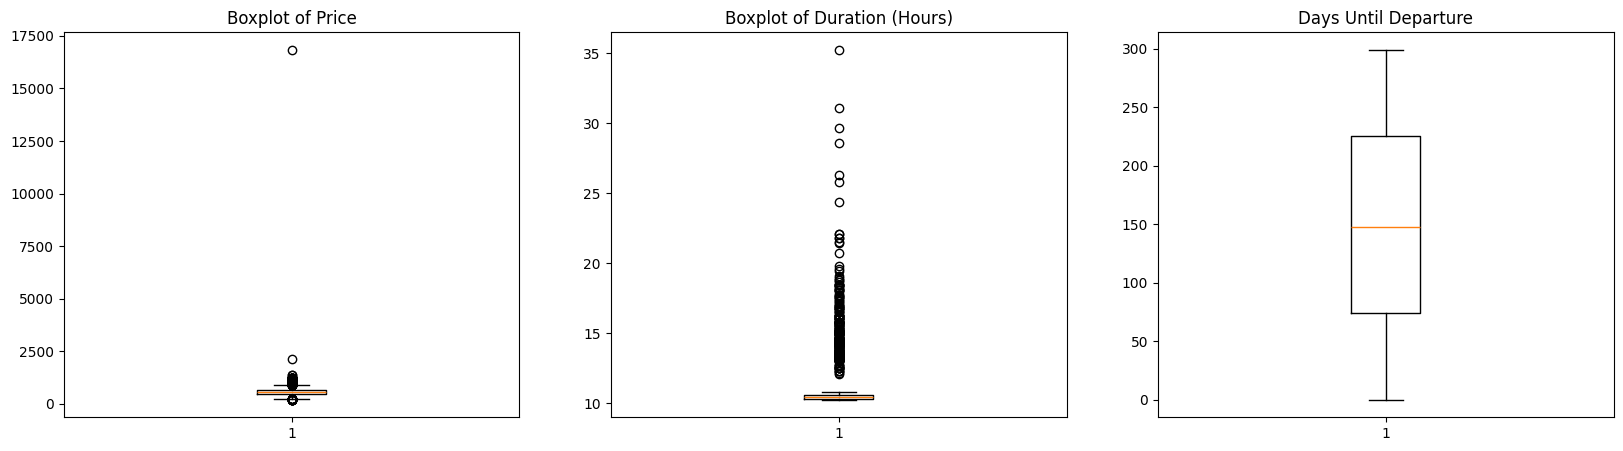

In [28]:
# We create a boxplot to visualize if there any outliers in the numeric variables.
fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].boxplot(df["Price"])
axs[0].set_title("Boxplot of Price")
axs[1].boxplot(df["Duration (Hours)"])
axs[1].set_title("Boxplot of Duration (Hours)")
axs[2].boxplot(df["Days Until Departure"])
axs[2].set_title("Days Until Departure")
plt.show()

In [29]:
# We also calculate z-scores to identify outliers in numerical variables
z_scores_price = stats.zscore(df["Price"])
z_scores_duration = stats.zscore(df["Duration (Hours)"])
z_scores_dud = stats.zscore(df["Days Until Departure"])
threshold = 3
outliers_price = df["Price"][abs(z_scores_price) > threshold]
outliers_duration = df["Duration (Hours)"][abs(z_scores_duration) > threshold]
outliers_dud = df["Days Until Departure"][abs(z_scores_dud) > threshold]


print("Outliers in Price:", outliers_price)
print("Outliers in Duration:", outliers_duration)
print("Outliers in Days Until Departure:", outliers_dud)

Outliers in Price: 2154     2127.0
2155    16838.0
Name: Price, dtype: float64
Outliers in Duration: 285     29.67
290     16.33
305     16.33
306     18.22
308     17.50
        ...  
2447    16.75
2448    18.08
2467    18.42
2468    18.33
2478    18.08
Name: Duration (Hours), Length: 65, dtype: float64
Outliers in Days Until Departure: Series([], Name: Days Until Departure, dtype: int64)


In [30]:
# Filter the dataframe to remove outliers in price
df= df[abs(z_scores_price) <= threshold]

# Filter the dataframe to remove outliers in duration
df = df[abs(z_scores_duration) <= threshold]

# If you want to remove outliers for both variables at the same time
df = df[(abs(z_scores_price) <= threshold) & (abs(z_scores_duration) <= threshold)]


/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_1939/1171092719.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[abs(z_scores_duration) <= threshold]
/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_1939/1171092719.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(abs(z_scores_price) <= threshold) & (abs(z_scores_duration) <= threshold)]


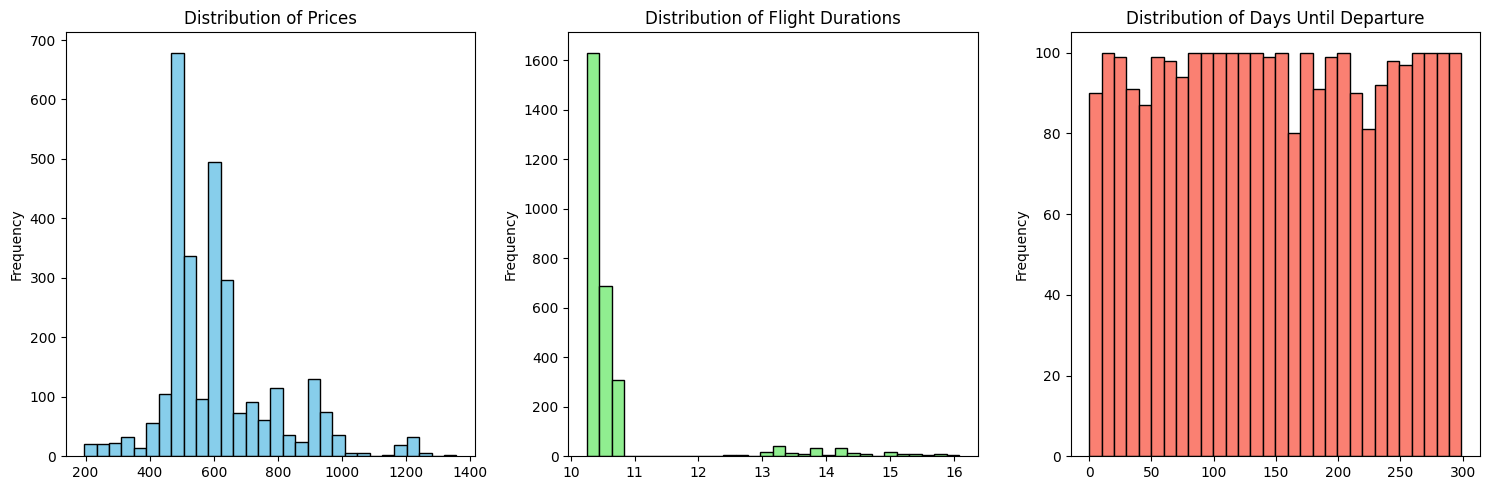

In [31]:
# We create 3 plots of our numeric variables to look at their distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each column
df['Price'].plot.hist(ax=axes[0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Prices')

df['Duration (Hours)'].plot.hist(ax=axes[1], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution of Flight Durations')

df['Days Until Departure'].plot.hist(ax=axes[2], bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Distribution of Days Until Departure')

plt.tight_layout()
plt.show()

### **Categorical variables**

In [32]:
# Since there are many unique Departure Times and Arrival Times it is decided to convert it into a categorical variable with 5 levels. 

# We define a function that should categorize 'Departure Time' and 'Arrival Time' based on some intervals we have defined.
def categorize_time(time):
    if time >= pd.to_datetime("00:00").time() and time < pd.to_datetime("04:00").time():
        return 'Night'
    elif time >= pd.to_datetime("04:00").time() and time < pd.to_datetime("08:00").time():
        return 'Early Morning'
    elif time >= pd.to_datetime("08:00").time() and time < pd.to_datetime("12:00").time():
        return 'Morning'
    elif time >= pd.to_datetime("12:00").time() and time < pd.to_datetime("18:00").time():
        return 'Afternoon'
    elif time >= pd.to_datetime("18:00").time() and time < pd.to_datetime("00:00").time():
        return 'Evening'
    else: 
        return 'Evening'

# Applying the newly created function in order to convert the columns into categorical variable
df['Departure Time'] = df['Departure Time'].apply(categorize_time)
df['Arrival Time'] = df['Arrival Time'].apply(categorize_time)

# Changing the data type
df['Departure Time'] = df['Departure Time'].astype('category')
df['Arrival Time'] = df['Arrival Time'].astype('category')

df.head()

,Airline,Source City,Departure Time,Number of Stops,Arrival Time,Destination City,Price,Search Date,Departure Date,Arrival Date,Days Until Departure,Duration (Hours)
0,Norse Atlantic Airways (UK),Los Angeles,Afternoon,0,Morning,London,244.0,2024-04-25,2024-04-25,2024-04-26,0,10.42
1,Virgin Atlantic,Los Angeles,Evening,0,Afternoon,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33
2,Virgin Atlantic,Los Angeles,Afternoon,0,Morning,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33
3,Delta,Los Angeles,Evening,0,Afternoon,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33
4,Delta,Los Angeles,Afternoon,0,Morning,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33


In [33]:
# Showing the distribution of each levels in the categorical variables in the dataframe
for column in df.select_dtypes(include='category').columns:
    print(f"Distribution for {column}:\n{df[column].value_counts()}\n")

Distribution for Airline:
Airline
British Airways                822
Virgin Atlantic                486
Delta                          379
Iberia                         363
Alaska Airlines                142
Norse Atlantic Airways (UK)    128
United                         121
American Airlines              115
Lufthansa                       69
Finnair                         68
Norse Atlantic Airways          53
WestJet                         25
SWISS                           25
jetBlue                         23
French Bee                      21
Aer Lingus                      20
Air France                      11
KLM                              6
Condor                           4
LOT                              1
Air Caraibes                     1
Scandinavian Airlines            1
LEVEL                            1
Spirit Airlines                  0
Turkish Airlines                 0
ITA Airways                      0
Name: count, dtype: int64

Distribution for Source City:

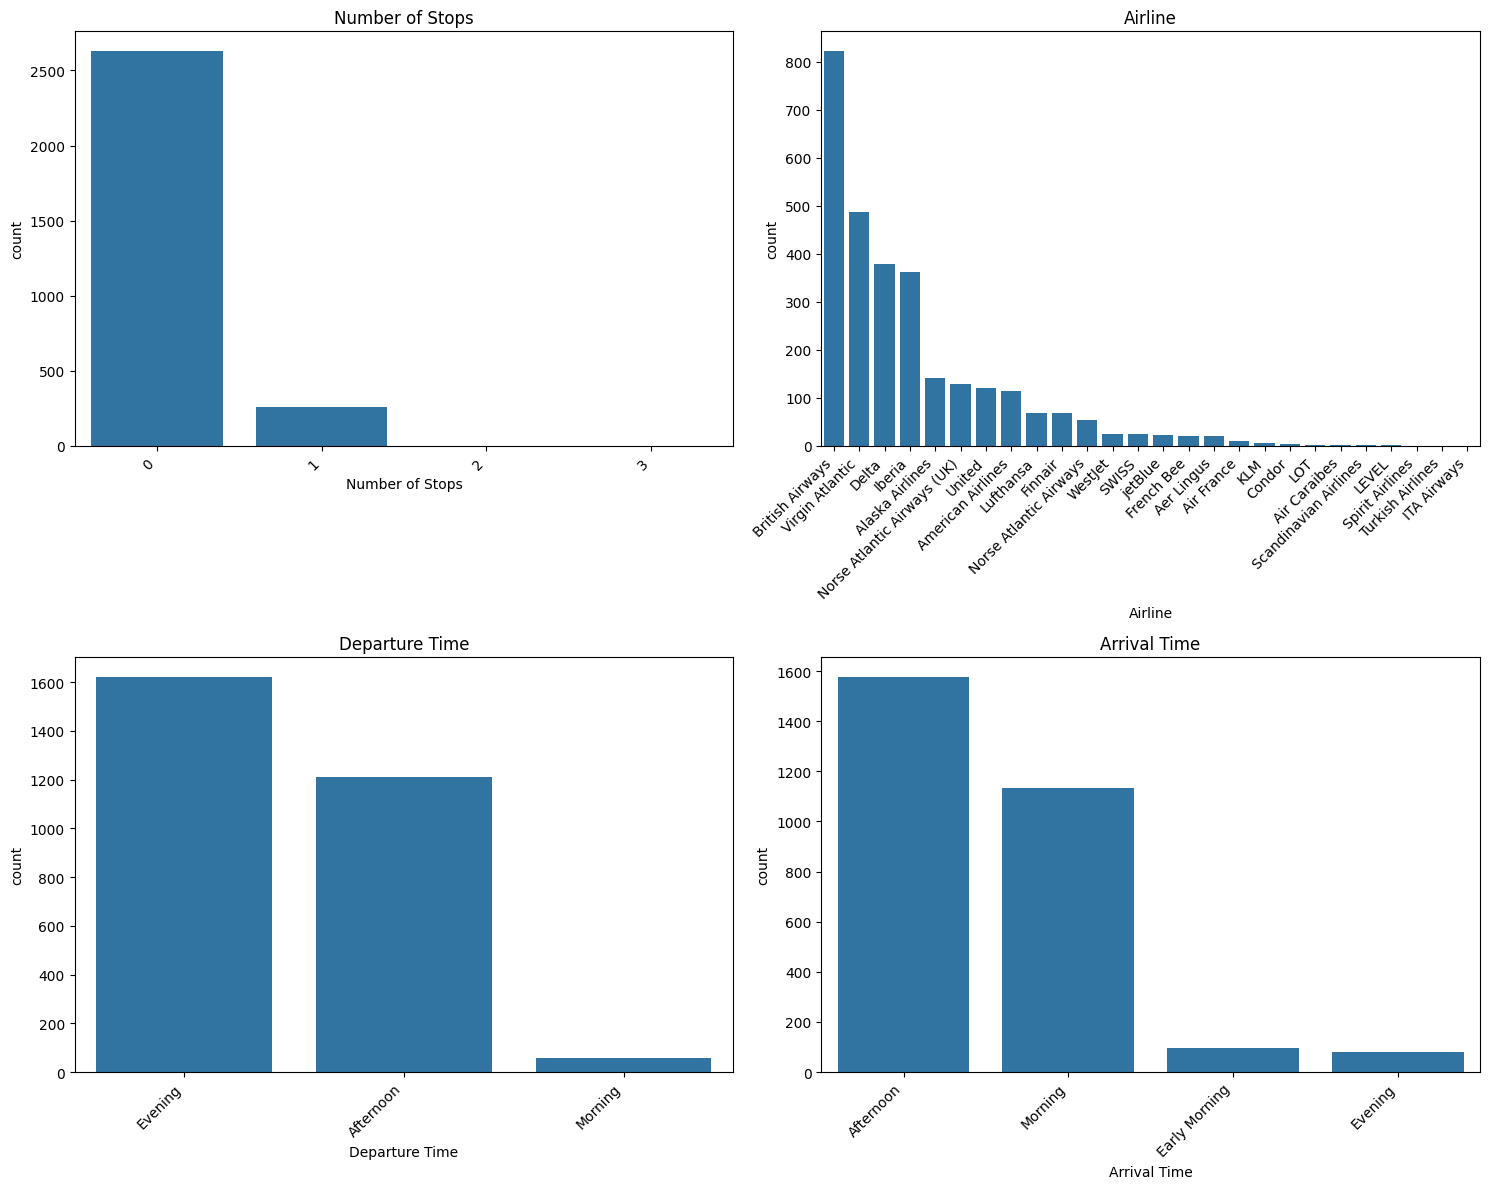

In [34]:
# Creating a plot to show the distribution of categorical variables
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjusted for a 2x2 grid of plots

# Plotting of 'Number of Stops' value counts sorted in ascending order
stops_counts = df['Number of Stops'].value_counts().sort_index()
sns.countplot(x='Number of Stops', data=df, order=stops_counts.index, ax=axes[0, 0])
axes[0, 0].set_title('Number of Stops')

# Plotting of 'Airline' value counts sorted in ascending order
airline_counts = df['Airline'].value_counts().sort_values(ascending=False)
sns.countplot(x='Airline', data=df, order=airline_counts.index, ax=axes[0, 1])
axes[0, 1].set_title('Airline')

# Plotting of 'Departure Time' value counts sorted in ascending order
departure_time_counts = df['Departure Time'].value_counts().sort_values(ascending=False)
sns.countplot(x='Departure Time', data=df, order=departure_time_counts.index, ax=axes[1, 0])
axes[1, 0].set_title('Departure Time')

# Plotting of 'Arrival Time' value counts sorted in ascending order
arrival_time_counts = df['Arrival Time'].value_counts().sort_values(ascending=False)
sns.countplot(x='Arrival Time', data=df, order=arrival_time_counts.index, ax=axes[1, 1])
axes[1, 1].set_title('Arrival Time')

# Rotating the labels on the x-axis to prevent overlap
for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()


### **Comparisons**

/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_1939/188662625.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Duration (Hours)', y='Price', ci=None)


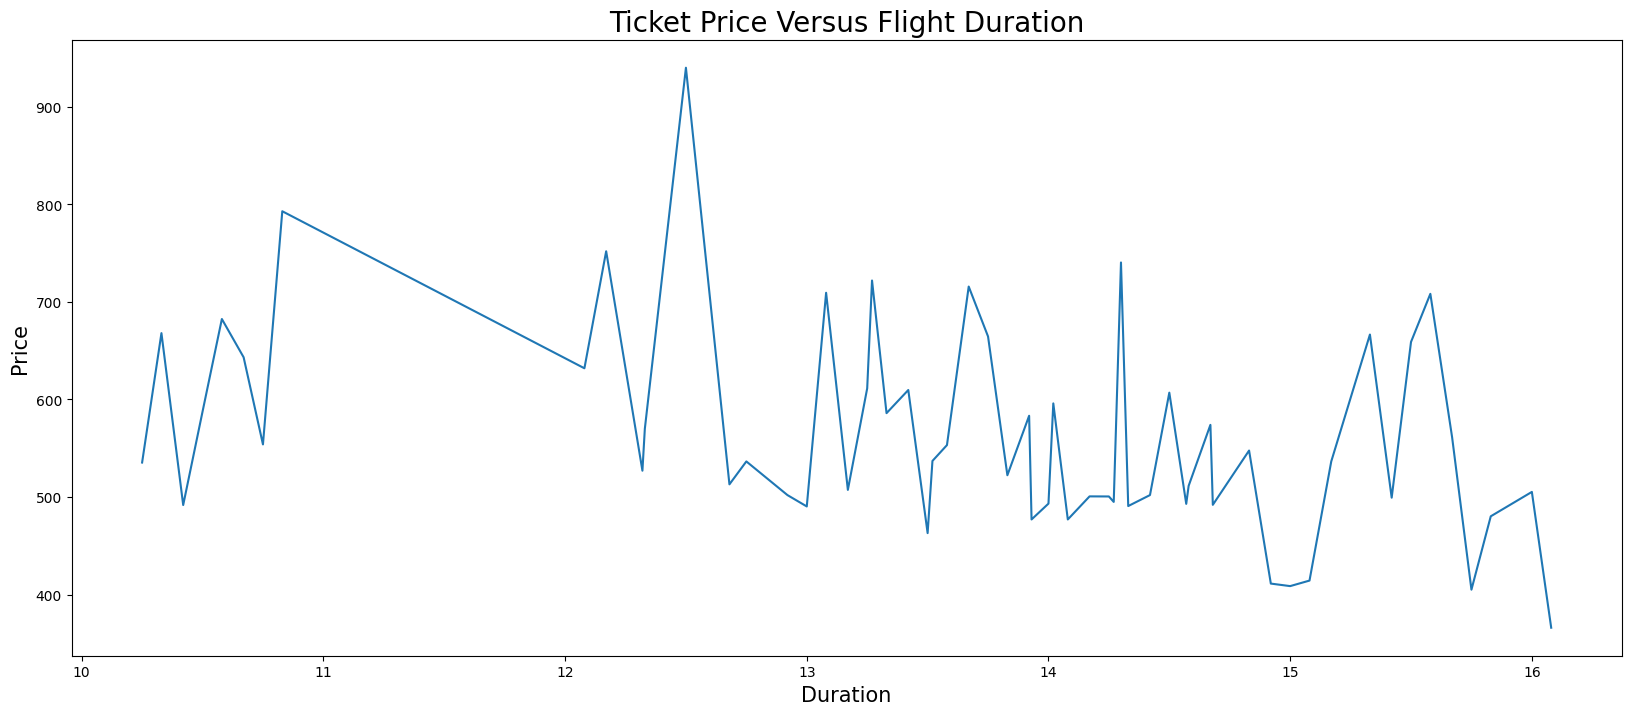

In [35]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Duration (Hours)', y='Price', ci=None)
plt.title('Ticket Price Versus Flight Duration', fontsize=20)
plt.xlabel('Duration', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_1939/3440798625.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Days Until Departure', y='Price', ci=None)


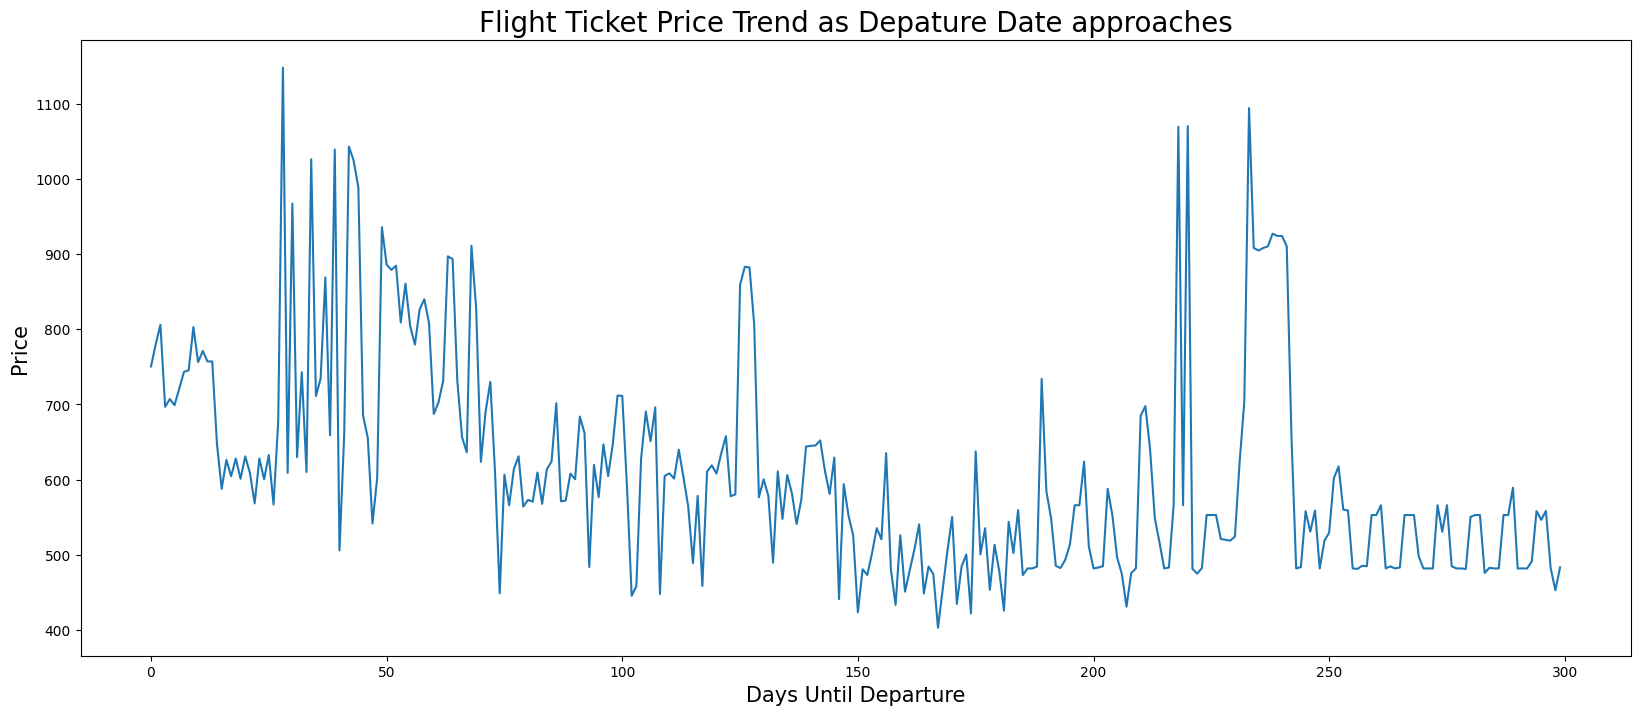

In [36]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Days Until Departure', y='Price', ci=None)
plt.title('Flight Ticket Price Trend as Depature Date approaches', fontsize=20)
plt.xlabel('Days Until Departure', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_1939/2629758941.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_price_per_airline = df.groupby('Airline')['Price'].mean().sort_values()


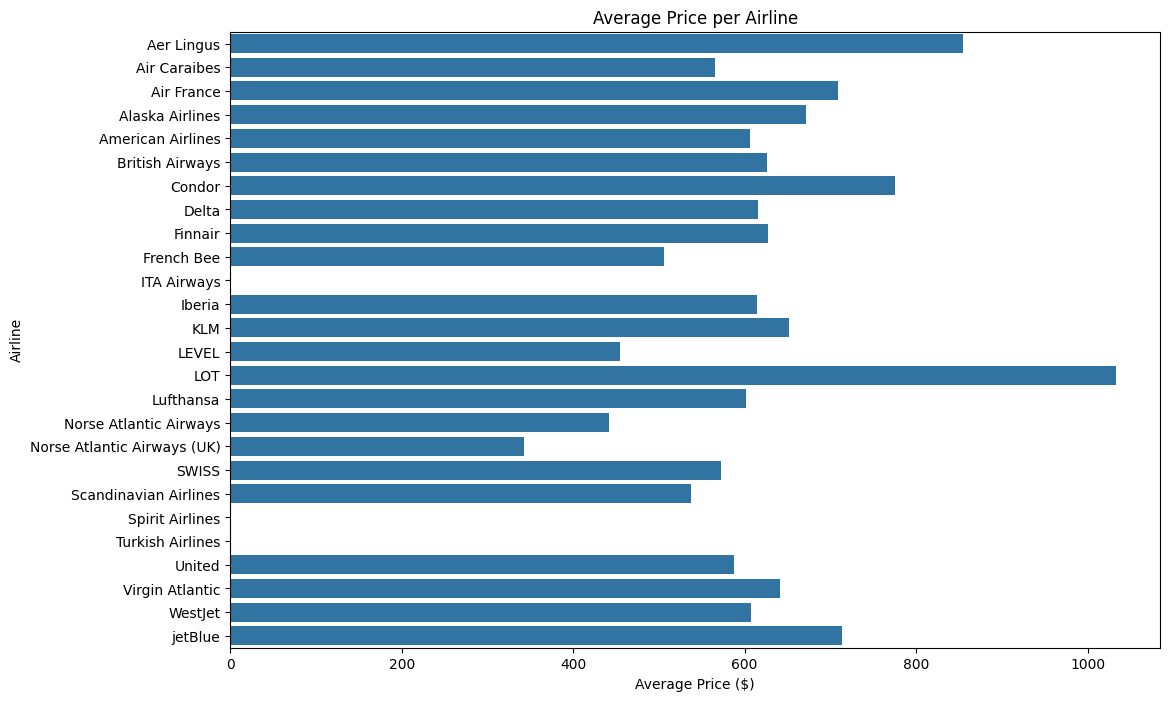

In [37]:
plt.figure(figsize=(12, 8))
average_price_per_airline = df.groupby('Airline')['Price'].mean().sort_values(False)
sns.barplot(x=average_price_per_airline.values, y=average_price_per_airline.index)
plt.title('Average Price per Airline')
plt.xlabel('Average Price ($)')
plt.ylabel('Airline')
plt.show()

/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_1939/508621098.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  departure_price = df.groupby('Departure Time')['Price'].mean()
/var/folders/yk/c34vj_zs38gcc2_lmpzdbdn40000gn/T/ipykernel_1939/508621098.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arrival_price = df.groupby('Arrival Time')['Price'].mean()


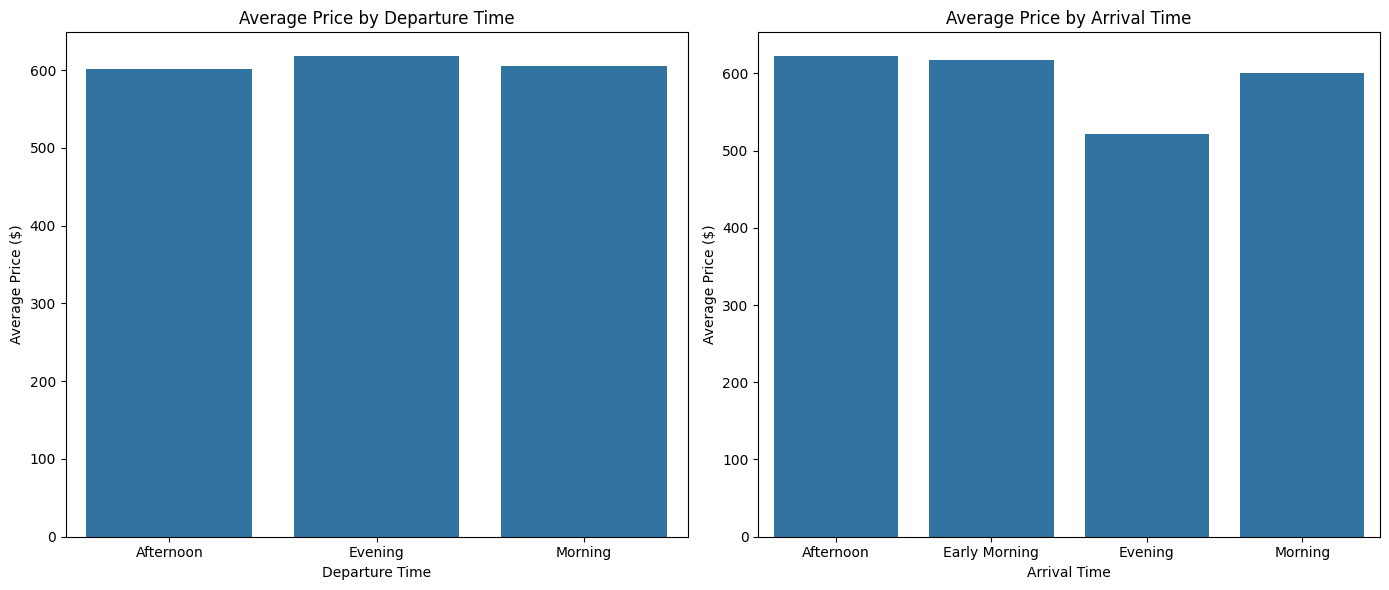

In [38]:
# Group by Departure Time and Arrival Time to find the average price for each category
departure_price = df.groupby('Departure Time')['Price'].mean()
arrival_price = df.groupby('Arrival Time')['Price'].mean()

# Plotting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=departure_price.index, y=departure_price.values)
plt.title('Average Price by Departure Time')
plt.xlabel('Departure Time')
plt.ylabel('Average Price ($)')

plt.subplot(1, 2, 2)
sns.barplot(x=arrival_price.index, y=arrival_price.values)
plt.title('Average Price by Arrival Time')
plt.xlabel('Arrival Time')
plt.ylabel('Average Price ($)')

plt.tight_layout()
plt.show()


**IF WE NEED TO SPLIT**

In [39]:
# Splitting the entire DataFrame into training (70%) and test sets (30%)
# train_df, test_df = train_test_split(df, test_size=0.3, random_state=45)

In [40]:
# Defining our target variable which is 'Price' which we would like to predict. 
#X = df.drop('Price', axis=1) # Dependent variables
#y = df['Price'] # Independent variable

# Split the data into a training set (70%) and a test set (30%) and set the seed to 45
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

## **Feature Engineering**

In [46]:
df

,Airline,Source City,Departure Time,Number of Stops,Arrival Time,Destination City,Price,Search Date,Departure Date,Arrival Date,Days Until Departure,Duration (Hours)
0,Norse Atlantic Airways (UK),Los Angeles,Afternoon,0,Morning,London,244.0,2024-04-25,2024-04-25,2024-04-26,0,10.42
1,Virgin Atlantic,Los Angeles,Evening,0,Afternoon,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33
2,Virgin Atlantic,Los Angeles,Afternoon,0,Morning,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33
3,Delta,Los Angeles,Evening,0,Afternoon,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33
4,Delta,Los Angeles,Afternoon,0,Morning,London,793.0,2024-04-25,2024-04-25,2024-04-26,0,10.33
...,...,...,...,...,...,...,...,...,...,...,...,...
2945,Delta,Los Angeles,Evening,0,Afternoon,London,473.0,2024-04-25,2025-02-18,2025-02-19,299,10.25
2946,British Airways,Los Angeles,Evening,0,Afternoon,London,490.0,2024-04-25,2025-02-18,2025-02-19,299,10.50
2947,British Airways,Los Angeles,Evening,0,Afternoon,London,490.0,2024-04-25,2025-02-18,2025-02-19,299,10.58
2948,Other Airlines,Los Angeles,Evening,0,Afternoon,London,493.0,2024-04-25,2025-02-18,2025-02-19,299,10.50


Before performing any feature engineering we split the data into a training and test set in order to minimize data leakage

In [54]:
# Assuming 'date_column' is your datetime column in DataFrame df
df['depart_month'] = df['Departure Date'].dt.month
df['depart_day'] = df['Departure Date'].dt.day
df['depart_weekday'] = df['Departure Date'].dt.weekday

df['depart_month'] = df['depart_month'].astype('category')
df['depart_day'] = df['depart_day'].astype('category')
df['depart_weekday'] = df['depart_weekday'].astype('category')

In [55]:
df.dtypes

Airline                         object
Source City                   category
Departure Time                category
Number of Stops               category
Arrival Time                  category
Destination City              category
Price                          float64
Search Date             datetime64[ns]
Departure Date          datetime64[ns]
Arrival Date            datetime64[ns]
Days Until Departure             int64
Duration (Hours)               float64
depart_month                  category
depart_day                    category
depart_weekday                category
dtype: object

In [41]:
# Calculate the percentage of each category
airline_counts = df['Airline'].value_counts(normalize=True)

# Find categories with less than 10% of the observations
small_categories = airline_counts[airline_counts < 0.025].index

# Lump small categories into "Other Airlines"
df['Airline'] = df['Airline'].apply(lambda x: "Other Airlines" if x in small_categories else x)

# Check the modified 'Airline' column
df['Airline'].value_counts(normalize=True)


Airline
British Airways                0.284922
Virgin Atlantic                0.168458
Delta                          0.131369
Iberia                         0.125823
Other Airlines                 0.114038
Alaska Airlines                0.049220
Norse Atlantic Airways (UK)    0.044367
United                         0.041941
American Airlines              0.039861
Name: proportion, dtype: float64

In [56]:
# One-hot encoding categorical variables
categorical_columns = ['Airline', 'Source City', 'Destination City', 'Departure Time', 'Arrival Time', 'depart_month', 'depart_day', 'depart_weekday']
data_encoded = pd.get_dummies(df, columns=categorical_columns)

# Splitting the data into features and target variable
X = data_encoded.drop('Price', axis=1)
y = data_encoded['Price']

**RYK OP TIL DE ANDRE I PREPROCESSING (Snak med de andre)**

In [64]:
# Drop the original datetime column
X.drop('Search Date', axis=1, inplace=True)
X.drop('Departure Date', axis=1, inplace=True)
X.drop('Arrival Date', axis=1, inplace=True)

In [65]:
X

,Number of Stops,Days Until Departure,Duration (Hours),Airline_Alaska Airlines,Airline_American Airlines,Airline_British Airways,Airline_Delta,Airline_Iberia,Airline_Norse Atlantic Airways (UK),Airline_Other Airlines,...,depart_day_29,depart_day_30,depart_day_31,depart_weekday_0,depart_weekday_1,depart_weekday_2,depart_weekday_3,depart_weekday_4,depart_weekday_5,depart_weekday_6
0,0,0,10.42,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1,0,0,10.33,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0,0,10.33,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0,0,10.33,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0,10.33,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945,0,299,10.25,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2946,0,299,10.50,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2947,0,299,10.58,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2948,0,299,10.50,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False


## **Decision Tree Regression**

In [66]:
# Loading libraries (move to top)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

*Parameters*:
- **max_depth**: The maximum depth of the tree. Deeper trees can model more complex patterns but might lead to overfitting.
- **min_samples_split**: The minimum number of samples a node must have before it can be split. Higher values prevent the model from learning overly specific patterns, thus reducing overfitting.
- **min_samples_leaf**: The minimum number of samples a leaf node must have. Again, higher values prevent overfitting.
- **max_features**: The number of features to consider when looking for the best split. Using fewer features can reduce overfitting but might increase bias.

In [67]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X, y)

DecisionTreeRegressor(max_depth=10)

In [ ]:
# Predicting the prices on the test set
predictions = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')


In [ ]:
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X_train.columns, max_depth=3)  # Limit depth for visualization purposes
plt.show()


**TUNING THE MODEL**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the model
dt = DecisionTreeRegressor()

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit grid search
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (MSE):", -grid_search.best_score_)